In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chinki86","key":"2b37558d5b359235a655730a30d3156b"}'}

In [2]:
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!pip install kaggle

!kaggle datasets download -d snap/amazon-fine-food-reviews

import zipfile
zip_ref = zipfile.ZipFile("amazon-fine-food-reviews.zip", 'r')
zip_ref.extractall("amazon")
zip_ref.close()

-rw-r--r-- 1 root root 64 Jan 31 05:00 kaggle.json
 99% 249M/251M [00:04<00:00, 36.1MB/s]
100% 251M/251M [00:04<00:00, 62.2MB/s]


# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [76]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [78]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [79]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [80]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [81]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [83]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [84]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [85]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [87]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [88]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [89]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [90]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [92]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [93]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [94]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [96]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:02<00:00, 2298.66it/s]


In [97]:
preprocessed_reviews

['product available victor traps unreal course total fly genocide pretty stinky right nearby',
 'used victor fly bait seasons ca not beat great product',
 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors',
 'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs',
 'glad cocker standard poodle puppy loves stuff trust brand superior nutrition compare labels previous feed pedigree mostly corn little dude healthy happy high energy glossy coat also superior nutrition produces smaller compact stools',
 'using food months find excellent fact two dogs coton de tulear standard poodle puppy love food thriving coats excellent condition overall structure perfect good tasting dog good good deal owner around best food 

In [0]:
vocab_size = len(sorted(set(preprocessed_reviews)))

In [99]:
vocab_size

4970

In [100]:
# importing keras and relevant libraries

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Flatten, Dropout
from keras.layers.embeddings import Embedding

# integer encode the sentences using keras library

encoded_docs = [one_hot(d, vocab_size) for d in preprocessed_reviews]
print(encoded_docs)

[[2565, 1100, 3231, 2356, 2765, 2720, 3954, 4106, 4068, 581, 4904, 3984, 3243], [3304, 3231, 4106, 183, 4003, 1652, 2302, 3981, 2252, 2565], [1332, 1949, 2587, 2084, 1573, 88, 2565, 1018, 3089, 2469, 4216, 3350, 3944, 77, 805, 1605, 2780, 2303, 3134, 1726, 4472, 4076, 2303, 1362, 2353, 3164, 4262, 2168, 4675, 1293, 2565, 4076, 4071, 4564, 2298, 3478, 3140, 1766, 1507], [3628, 1569, 2374, 3806, 2565, 3973, 1726, 4921, 4472, 848, 1675, 3978, 1669, 4921, 82, 2581, 635], [1156, 330, 4455, 4729, 2392, 2147, 2300, 441, 3746, 4827, 2447, 3305, 4045, 2979, 3791, 4840, 3405, 653, 3584, 1860, 729, 4563, 4556, 1028, 4457, 3815, 3886, 4827, 2447, 777, 720, 2719, 3466], [1514, 2351, 4444, 2891, 3285, 2630, 2581, 4524, 1499, 452, 1251, 4455, 4729, 2392, 1018, 2351, 450, 1610, 3285, 1728, 1529, 1916, 4057, 1569, 3373, 2985, 1569, 1569, 4083, 858, 4717, 4260, 2351, 3493, 3304, 3285], [1834, 3227, 4050, 3739, 390, 1610, 3818, 1685, 2351, 3227, 2313, 3234], [3244, 2083, 26, 1442, 2821, 3949, 2321, 3156,

In [0]:
# split the data into train and test

y = final["Score"].values

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(encoded_docs, y, test_size=0.2, random_state=42)

In [102]:
len(y)

4986

In [103]:
len(encoded_docs)

4986

In [104]:
# truncate and/or pad input sequences
max_review_length = 100
X_train = pad_sequences(X_train, maxlen=max_review_length)
X_test =  pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(3988, 100)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 1719 4084 4173 2612 2828 3705 4803 1285  525 3802 2302
 2882  181]


**1. Model 1 One LSTM**

In [110]:
# create the model
embedding_vecor_length = 50

# Initialising the model
model_1 = Sequential()

# Adding embedding
model_1.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length))

# Adding Dropout
model_1.add(Dropout(0.2))

# Adding first LSTM layer
model_1.add(LSTM(100))

# Adding Dropout
model_1.add(Dropout(0.2))

# Adding output layer
model_1.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model_1.summary())

# Compiling the model
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_1 = model_1.fit(X_train, Y_train, nb_epoch=10, batch_size=64 ,verbose=1,validation_data=(X_test, Y_test))



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 50)           248500    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 309,001
Trainable params: 309,001
Non-trainable params: 0
_________________________________________________________________
None
Train on 3988 samples, validate on 998 samples
Epoch 1/10
3988/3988 [==============================] - 20s 5ms/step - loss: 0.4768 

Accuracy: 87.47%


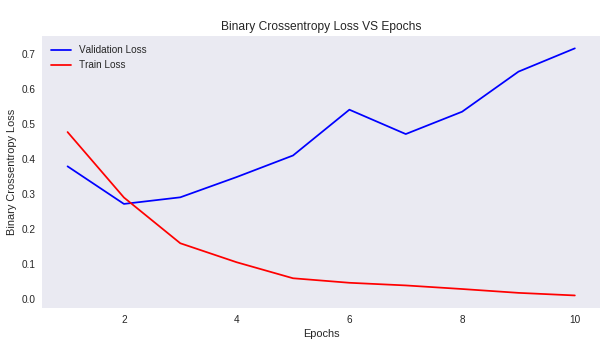

In [111]:
# We will Plot the results and evaluate

# this function is used for plotting Loss vs Number of Epochs 
def plt_dynamic(x, vy, ty):
  plt.figure(figsize=(10,5))
  plt.plot(x, vy, 'b', label="Validation Loss")
  plt.plot(x, ty, 'r', label="Train Loss")                          
  plt.xlabel('Epochs') 
  plt.ylabel('Binary Crossentropy Loss')
  plt.title('\nBinary Crossentropy Loss VS Epochs')
  plt.legend()
  plt.grid()
  plt.show()
  
  
# Final evaluation of the model
scores = model_1.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Test and train accuracy of the model
model_1_test = scores[1]
model_1_train = max(history_1.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,11))

# Validation loss
vy = history_1.history['val_loss']
# Training loss
ty = history_1.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

**2. Model 2 Two LSTM Layers**

In [116]:
# create the model
embedding_vecor_length = 32

# Initialising the model
model_2 = Sequential()

# Adding embedding
model_2.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length))

# Adding first LSTM layer
model_2.add(LSTM(128,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))

# Adding second LSTM layer
model_2.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))

# Adding output layer
model_2.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model_2.summary())

# Compiling the model
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_2 = model_2.fit(X_train, Y_train, nb_epoch=10, batch_size=128 ,verbose=1,validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 100, 32)           159040    
_________________________________________________________________
lstm_34 (LSTM)               (None, 100, 128)          82432     
_________________________________________________________________
lstm_35 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 373,185
Trainable params: 373,185
Non-trainable params: 0
_________________________________________________________________
None
Train on 3988 samples, validate on 998 samples
Epoch 1/10
3988/3988 [==============================] - 24s 6ms/step - loss: 0.5020 - acc: 0.8257 - val_loss: 0.4341 - val_acc: 0.8437
Epoch 2/10
3988/3988 [==============================] - 16s 4ms/step - loss: 0.42

Accuracy: 86.47%


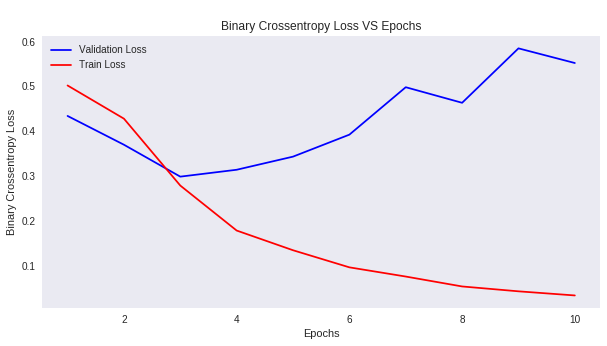

In [117]:
# Final evaluation of the model
scores = model_2.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Test and train accuracy of the model
model_2_test = scores[1]
model_2_train = max(history_2.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,11))

# Validation loss
vy = history_2.history['val_loss']
# Training loss
ty = history_2.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

**Model 3 Three LSTM Layers**

In [118]:
# create the model
embedding_vecor_length = 32

# Initialising the model
model_3 = Sequential()

# Adding embedding
model_3.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length))

# Adding first LSTM layer
model_3.add(LSTM(128,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))

# Adding second LSTM layer
model_3.add(LSTM(256,return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

# Adding third LSTM layer
model_3.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))

# Adding output layer
model_3.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model_3.summary())

# Compiling the model
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_3 = model_3.fit(X_train, Y_train, nb_epoch=10, batch_size=512 ,verbose=1,validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 100, 32)           159040    
_________________________________________________________________
lstm_36 (LSTM)               (None, 100, 128)          82432     
_________________________________________________________________
lstm_37 (LSTM)               (None, 100, 256)          394240    
_________________________________________________________________
lstm_38 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 129       
Total params: 832,961
Trainable params: 832,961
Non-trainable params: 0
_________________________________________________________________
None
Train on 3988 samples, validate on 998 samples
Epoch 1/10
3988/3988 [==============================] - 16s 4ms/step - loss: 0.5878 

Accuracy: 87.47%


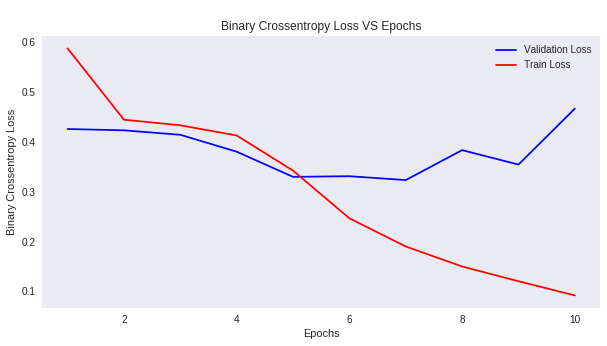

In [119]:
# Final evaluation of the model
scores = model_3.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Test and train accuracy of the model
model_3_test = scores[1]
model_3_train = max(history_3.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,11))

# Validation loss
vy = history_3.history['val_loss']
# Training loss
ty = history_3.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

In [121]:
# Using Pretty Table we showcas our train and test accuracies with different models

from prettytable import PrettyTable

# Names of models
names = ['RNN With 1 LSTM Layer','RNN With 2 LSTM Layers','RNN With 3 LSTM Layers']

# Training accuracies
train_acc = [model_1_train,model_2_train,model_3_train]

# Test accuracies
test_acc = [model_1_test,model_2_test,model_3_test]

numbering = [1,2,3]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+------------------------+--------------------+--------------------+
| S.NO. |         MODEL          | Training Accuracy  |   Test Accuracy    |
+-------+------------------------+--------------------+--------------------+
|   1   | RNN With 1 LSTM Layer  | 0.9969909728589723 | 0.8747494988785478 |
|   2   | RNN With 2 LSTM Layers | 0.9884653961287817 | 0.8647294587983875 |
|   3   | RNN With 3 LSTM Layers | 0.9714142418912086 | 0.8747494988785478 |
+-------+------------------------+--------------------+--------------------+
